In [1]:
import csv
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as mplcm
import matplotlib as mpl
import scipy
import math
import copy
import os
from datetime import datetime
import random
import multiprocessing
import importlib
import inspect
import pickle

import bioscrape as bs
import bioscrape.lineage as bs_lineage

import seaborn as sns
# rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
# sns.set(rc=rc)
# sns.set(style = "ticks")

sns.set_context('paper')

%matplotlib inline
#%config InlineBackend.figure_f.ormats=['svg']
color_list = ['r', 'k', 'b','g','y','m','c']
mpl.rc('axes', prop_cycle=(mpl.cycler('color', color_list) ))
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12)

# Utility funcs

In [2]:
def make_growth_model(rxns, species, params, initial_conditions, selection = False):
    '''
    Adds some scaffolding to a model to put it in an exponentially-growing cell 
    with growth rate params['k_gamma']. Parameters are of the same type and 
    specification as used by bioscrape.types.Model.
    '''
    m = bs_lineage.LineageModel(reactions = rxns, 
                                parameters = params,
                                species = species,
                                initial_condition_dict = initial_conditions)

    # Multiplicative growth with rate set by k_gamma, but don't grow if there's 
    # no DNA present. 
    if selection:
        vol_rule_str = "volume * k_gamma * Heaviside("
        for s in species:
            if "DNA" in s:
                vol_rule_str += f"{s} + "
        
        vol_rule_str = vol_rule_str[:-2]
        vol_rule_str += "- 1)"
    else:
        vol_rule_str = "volume * k_gamma"
    m.create_volume_rule("ode", {"equation": vol_rule_str})

    # Divide when volume doubles (to 2), splitting all species binomially, with a small amount
    # of noise in volume partitioning.
    vsplit = bs_lineage.LineageVolumeSplitter(m, 
              options = {"default": "binomial"},
              partition_noise = 0.05)
    division_vol = 2
    m.create_division_rule("volume", {"threshold":division_vol}, vsplit)

    m.py_initialize()
    return m

In [3]:
def simulate_with_caching(cache_filename, **turbidostat_args):
    '''Wraps simulate_turbidostat_models, but memoizes the results in a file 
    cached_results/<cache_filename>. If that cache file exists, then the model in it 
    will be used instead of running the simulation again. Delete the cache file to
    run the simulation fresh. 
    '''
    full_cache_filename = os.path.join('cached_results', cache_filename)
    if os.path.isfile(full_cache_filename):
        print(f"Using cached results from file {full_cache_filename}.")
        results = pickle.load(open(full_cache_filename, 'rb'))
    else:
        results = bs_lineage.py_SimulateTurbidostat(return_dataframes = False, 
                                                    return_sample_times = False,
                                                    **turbidostat_args)         
        pickle.dump(results, open(full_cache_filename, 'wb'))
    return results

# The CRISPRlator 

# Deterministic:

In [4]:
# All parameters in units of 1/sec or 1/nM/sec
cas_params = dict()
cas_params['k_gamma']    = math.log(2) / (30 * 60)
cas_params['k_gRNA_prod_rate']   = 5.0 / 60 
cas_params['k_gRNA_deg_rate']    = math.log(2) / 100.0
cas_params['k_dCas_prod_rate']   = 4.5 * 1.0 / 60 # 4.5x other simulations
cas_params['k_dCas_deg_rate']    = 0 * cas_params['k_gamma']
cas_params['k_gRNA_bind']      = math.log(2) / 375.0
cas_params['k_gRNA_unbind']    = 0
cas_params['k_complex_bind']   = math.log(2) / 60.0
cas_params['k_complex_unbind'] = 0 #params['k_complex_bind'] / 1000.0 #<-- Just a guess!
cas_params['k_gRNA_leak_rate']   = 0# params['gRNA_prod_rate'] / 100.0

In [5]:
def make_CRISPRlator_model(params, initial_conditions, lineage = False, selection = False):
    '''
    Assumes abundant dCas, instant and perfect binding. 
    '''
    rxns = []
    species = ['dCas']
    rxns.append(([], ['dCas'], 'massaction', {'k': params["k_dCas_prod_rate"]})) # dCas prod rate
    rxns.append((['dCas'], [], 'massaction', {'k': params['k_dCas_deg_rate']}))  # dCas degradation
    for i in range(1, 6):
        prev_i = (i-2)%5 + 1
        species += [f"g{i}", f"DNA{i}", f"dCas_g{i}", f"DNA{prev_i}_g{i}"]
        rxns.append(([f"DNA{i}"], [f"DNA{i}", f"g{i}"], 'massaction', {'k': params['k_gRNA_prod_rate']})) # gRNA production
        rxns.append(([f"g{i}"], [], 'massaction', {'k': params["k_gRNA_deg_rate"]})) # gRNA Degradation
        rxns.append(([f"g{i}", "dCas"], [f"dCas_g{i}"], 'massaction', {'k': params["k_gRNA_bind"]})) # gRNA binding to dCas
        rxns.append(([f"dCas_g{i}"], ["dCas", f"g{i}"], 'massaction', {'k': params["k_gRNA_unbind"]})) # gRNA unbinding from dCas
        rxns.append(([f"dCas_g{i}"], [], 'massaction', {'k': params['k_dCas_deg_rate']})) # dCas:gRNA degradation
        rxns.append(([f"dCas_g{i}", f"DNA{prev_i}"], [f"DNA{prev_i}_g{i}"], 'massaction', {'k': params["k_complex_bind"]})) # dCas complex binding to target
        rxns.append(([f"DNA{prev_i}_g{i}"], [f"dCas:g{i}", f"DNA{prev_i}"], 'massaction', {'k': params["k_gamma"]})) # dCas complex unbinding from target
        
    if not lineage:
        rxns.append((["dCas"], [], 'massaction', {'k': params["k_gamma"]})) # dCas dilution
        for i in range(1, 6):
            prev_i = (i-2)%5 + 1
            rxns.append(([f"g{i}"], [], 'massaction', {'k':params['k_gamma']})) # 
            rxns.append(([f"dCas_g{i}"], [], 'massaction', {'k': params['k_gamma']}))
            rxns.append(([f"DNA{prev_i}_g{i}"], [f"DNA{prev_i}"], 'massaction', {'k': params['k_gamma']}))
        return bs.types.Model(species = species, parameters = params, reactions = rxns,
                              initial_condition_dict = initial_conditions)
    else:
        m = make_growth_model(rxns, species, params, initial_conditions)
        return m

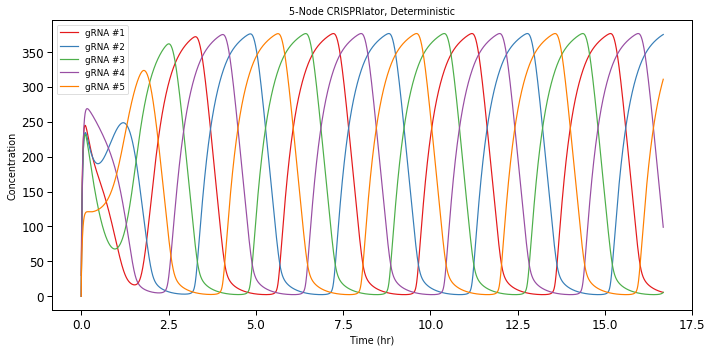

In [6]:
initial_conditions = {
    "DNA1": 30,
    "DNA2": 30,
    "DNA3": 30,
    "DNA4": 30,
    "DNA5": 30,
    "dCas": 43,
    "g1": 30
}
simple_CRISPRlator_m = make_CRISPRlator_model(cas_params, initial_conditions, lineage = False)
ts = np.linspace(0, 60000, 10000)
simple_CRISPR_results = bs.simulator.py_simulate_model(ts, Model = simple_CRISPRlator_m, stochastic = False)

color_list = ['#e41a1c', '#377eb8', '#4daf4a', 
                          '#984ea3', '#ff7f00']
plt.figure(figsize = (10,5))
for i in range(5):
    j = i+1
    prev_i = (j-2)%5 + 1
    gRNA_concs = simple_CRISPR_results[f"g{j}"] + simple_CRISPR_results[f"dCas_g{j}"] + simple_CRISPR_results[f"DNA{prev_i}_g{j}"]
    plt.plot(ts/3600, gRNA_concs, color = color_list[i], label = f"gRNA #{j}")

plt.xlabel("Time (hr)")
plt.ylabel("Concentration")
plt.title("5-Node CRISPRlator, Deterministic")
plt.legend()
plt.tight_layout()
plt.show()


# Stochastic

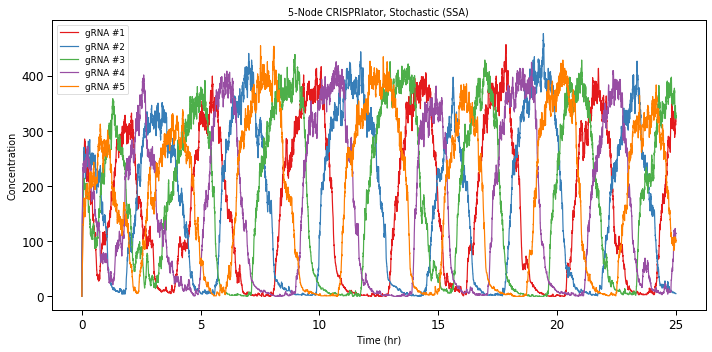

In [7]:
initial_conditions = {
    "DNA1": 30,
    "DNA2": 30,
    "DNA3": 30,
    "DNA4": 30,
    "DNA5": 30,
    "dCas": 43,
    "g1": 30
}
ts = np.linspace(0, 90000, 10000)
simple_stoch_results = bs.simulator.py_simulate_model(ts, Model = simple_CRISPRlator_m, stochastic = True)

color_list = ['#e41a1c', '#377eb8', '#4daf4a', 
                          '#984ea3', '#ff7f00']
plt.figure(figsize = (10,5))
for i in range(5):
    j = i+1
    prev_i = (j-2)%5 + 1
    gRNA_concs = simple_stoch_results[f"g{j}"] + simple_stoch_results[f"dCas_g{j}"] + simple_stoch_results[f"DNA{prev_i}_g{j}"]
    plt.plot(ts/3600, gRNA_concs, color = color_list[i], label = f"gRNA #{j}")

plt.xlabel("Time (hr)")
plt.ylabel("Concentration")
plt.legend()
plt.title("5-Node CRISPRlator, Stochastic (SSA)")
plt.tight_layout()
plt.show()


# Lineages

### Trivial model (bad)

In [8]:
def make_CRISPRlator_trivial(params, initial_conditions, lineage = False, selection = False):
    '''
    Assumes abundant dCas, instant and perfect binding. Plasmids replicate the dumb way.
    '''
    rxns = []
    species = ['dCas']
    rxns.append(([], ['dCas'], 'massaction', {'k': params["k_dCas_prod_rate"]})) # dCas prod rate
    rxns.append((['dCas'], [], 'massaction', {'k': params['k_dCas_deg_rate']}))  # dCas degradation
    for i in range(1, 6):
        prev_i = (i-2)%5 + 1
        species += [f"g{i}", f"DNA{i}", f"dCas:g{i}", f"DNA{prev_i}:g{i}"]
        
        # Plasmid replication (trivial)
        rxns.append(([f"DNA{i}"], [f"DNA{i}", f"DNA{i}"], 'massaction', {'k': params['k_gamma']}))
        rxns.append(([f"DNA{prev_i}_g{i}"], [f"DNA{prev_i}", f"DNA{prev_i}", f"dCas_{i}"], 'massaction', {'k': params['k_gamma']}))        
        
        # Everything else
        rxns.append(([f"DNA{i}"], [f"DNA{i}", f"g{i}"], 'massaction', {'k': params['k_gRNA_prod_rate']})) # gRNA production
        rxns.append(([f"g{i}"], [], 'massaction', {'k': params["k_gRNA_deg_rate"]})) # gRNA Degradation
        rxns.append(([f"g{i}", "dCas"], [f"dCas_g{i}"], 'massaction', {'k': params["k_gRNA_bind"]})) # gRNA binding to dCas
        rxns.append(([f"dCas_g{i}"], ["dCas", f"g{i}"], 'massaction', {'k': params["k_gRNA_unbind"]})) # gRNA unbinding from dCas
        rxns.append(([f"dCas_g{i}"], [], 'massaction', {'k': params['k_dCas_deg_rate']})) # dCas:gRNA degradation
        rxns.append(([f"dCas_g{i}", f"DNA{prev_i}"], [f"DNA{prev_i}_g{i}"], 'massaction', {'k': params["k_complex_bind"]})) # dCas complex binding to target
        #rxns.append(([f"DNA{prev_i}:g{i}"], [f"dCas:g{i}", f"DNA{prev_i}"], 'massaction', {'k': params["k_gamma"]})) # dCas complex unbinding from target
        
    if not lineage:
        rxns.append((["dCas"], [], 'massaction', {'k': params["k_gamma"]})) # dCas dilution
        for i in range(1, 6):
            prev_i = (i-2)%5 + 1
            rxns.append(([f"g{i}"], [], 'massaction', {'k':params['k_gamma']})) # 
            rxns.append(([f"dCas_g{i}"], [], 'massaction', {'k': params['k_gamma']}))
            rxns.append(([f"DNA{prev_i}_g{i}"], [f"DNA{prev_i}"], 'massaction', {'k': params['k_gamma']}))
        return bs.types.Model(species = species, parameters = params, reactions = rxns,
                              initial_condition_dict = initial_conditions)
    else:
        m = make_growth_model(rxns, species, params, initial_conditions, selection)
        return m

In [9]:
initial_conditions = {
    "DNA1": 30,
    "DNA2": 30,
    "DNA3": 30,
    "DNA4": 30,
    "DNA5": 30,
    "dCas": 43,
    "g1": 30
}

seed = 42334
np.random.seed(42334)
bs.random.py_seed_random(42334)

start_time = datetime.now()
# The trivial model spreads more over time, so worth simulating longer
# to get more distributional info.
n_generations = 50
t_max = n_generations*30*60
temp_ts = np.linspace(0, t_max, 4000)#n_generations*100)
sample_times = np.linspace(0, t_max, 100) #<- Lineages doesn't like having too few
                                                # sample times, don't use just one or two.

trivial_model = make_CRISPRlator_trivial(cas_params, initial_conditions, lineage = True)    

#     all_distributions[model_name] = bs_lineage.py_SimulateCellLineage(temp_ts, [], initial_cell_count = 1, Model = model)
#     [bs.simulator.py_simulate_model(temp_ts, model, stochastic = True) for i in range(2)]
trivial_results = simulate_with_caching('CRISPR_trivial.pkl',
                                        initial_cell_states = 1, 
                                        timepoints = temp_ts,
                                        sample_times = sample_times,
                                        population_cap = 1,
                                        Model = trivial_model, debug = False)                                                                                  
end_time = datetime.now()
print("execution time: " + str(end_time - start_time))

execution time: 0:00:02.264456


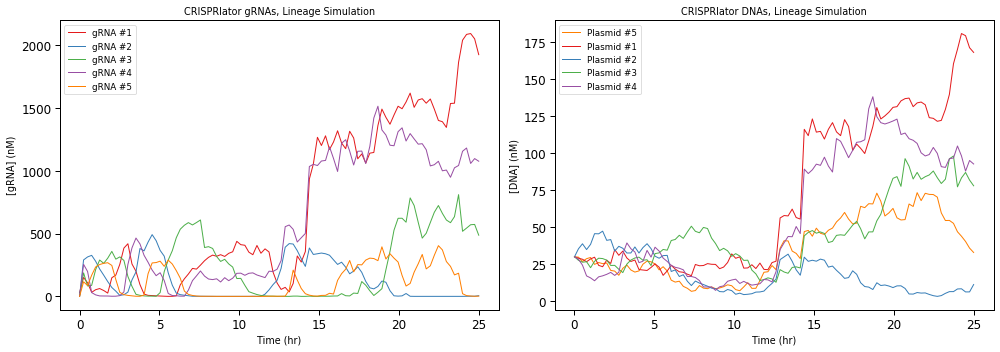

In [10]:
plt.figure(figsize = (14,5))

all_states = [cs for state_list in trivial_results for cs in state_list]
plotting_ts = [cs.py_get_time()/3600 for cs in all_states]

subplot1 = plt.subplot(121)
subplot2 = plt.subplot(122)
for i in range(1, 6):
    prev_i = prev_i = (i-2)%5 + 1
    gRNA_idx = trivial_model.get_species2index()[f"g{i}"]
    dCas_idx = trivial_model.get_species2index()[f"dCas_g{i}"]
    dna_idx = trivial_model.get_species2index()[f"DNA{prev_i}_g{i}"]
    bare_dna_idx = trivial_model.get_species2index()[f"DNA{prev_i}"]

    
    bare_gRNA = [cs.py_get_state()[gRNA_idx]/cs.py_get_volume() for cs in all_states]
    dCas_gRNA = [cs.py_get_state()[dCas_idx]/cs.py_get_volume() for cs in all_states]
    dna_gRNA = [cs.py_get_state()[dna_idx]/cs.py_get_volume() for cs in all_states]
    bare_dna = [cs.py_get_state()[bare_dna_idx]/cs.py_get_volume() for cs in all_states]
    total_gRNA = [bare_gRNA[i] + dCas_gRNA[i] + dna_gRNA[i] for i in range(len(all_states))]
    total_dna = [bare_dna[i] + dna_gRNA[i] for i in range(len(all_states))]

#     plt.subplot(121)
    subplot1.plot(plotting_ts, total_gRNA, label = f"gRNA #{i}", 
                color = color_list[i-1], lw = 1)
#     plt.subplot(122)
    subplot2.plot(plotting_ts, total_dna, label = f"Plasmid #{prev_i}",
                color = color_list[prev_i-1], lw = 1)
    
subplot1.set_xlabel("Time (hr)")
subplot1.set_ylabel("[gRNA] (nM)")
subplot1.set_title(f"CRISPRlator gRNAs, Lineage Simulation")
subplot1.legend()

subplot2.set_xlabel("Time (hr)")
subplot2.set_ylabel("[DNA] (nM)")
subplot2.set_title("CRISPRlator DNAs, Lineage Simulation")
subplot2.legend()
plt.tight_layout()
plt.show()

### Dummy model

In [11]:
def make_CRISPRlator_dummy(params, initial_conditions, lineage = False, selection = False):
    '''
    Assumes abundant dCas, instant and perfect binding. Plasmids replicate the dumb way.
    '''
    rxns = []
    species = ['dCas']
    rxns.append(([], ['dCas'], 'massaction', {'k': params["k_dCas_prod_rate"]})) # dCas prod rate
    rxns.append((['dCas'], [], 'massaction', {'k': params['k_dCas_deg_rate']}))  # dCas degradation
    for i in range(1, 6):
        prev_i = (i-2)%5 + 1
        species += [f"g{i}", f"DNA{i}", f"dCas_g{i}", f"DNA{prev_i}_g{i}"]
        
        # Plasmid replication (dummy-triggered)
        rxns.append(([], [f"R{i}"], 'massaction', {'k': initial_conditions["DNA1"]*params['k_gamma']}))
        rxns.append(([f"DNA{i}", f"R{i}"], [f"DNA{i}", f"DNA{i}"], 'massaction', {'k': 10*params['k_gamma']}))
        rxns.append(([f"DNA{prev_i}_g{i}", f"R{prev_i}"], [f"DNA{prev_i}", f"DNA{prev_i}", f"dCas_g{i}"], 'massaction', {'k': 10*params['k_gamma']}))        
        
        # Everything else
        rxns.append(([f"DNA{i}"], [f"DNA{i}", f"g{i}"], 'massaction', {'k': params['k_gRNA_prod_rate']})) # gRNA production
        rxns.append(([f"g{i}"], [], 'massaction', {'k': params["k_gRNA_deg_rate"]})) # gRNA Degradation
        rxns.append(([f"g{i}", "dCas"], [f"dCas_g{i}"], 'massaction', {'k': params["k_gRNA_bind"]})) # gRNA binding to dCas
        rxns.append(([f"dCas_g{i}"], ["dCas", f"g{i}"], 'massaction', {'k': params["k_gRNA_unbind"]})) # gRNA unbinding from dCas
        rxns.append(([f"dCas_g{i}"], [], 'massaction', {'k': params['k_dCas_deg_rate']})) # dCas:gRNA degradation
        rxns.append(([f"dCas_g{i}", f"DNA{prev_i}"], [f"DNA{prev_i}_g{i}"], 'massaction', {'k': params["k_complex_bind"]})) # dCas complex binding to target
        #rxns.append(([f"DNA{prev_i}:g{i}"], [f"dCas:g{i}", f"DNA{prev_i}"], 'massaction', {'k': params["k_gamma"]})) # dCas complex unbinding from target
        
    if not lineage:
        rxns.append((["dCas"], [], 'massaction', {'k': params["k_gamma"]})) # dCas dilution
        for i in range(1, 6):
            prev_i = (i-2)%5 + 1
            rxns.append(([f"g{i}"], [], 'massaction', {'k':params['k_gamma']})) # 
            rxns.append(([f"dCas_g{i}"], [], 'massaction', {'k': params['k_gamma']}))
            rxns.append(([f"DNA{prev_i}_g{i}"], [f"DNA{prev_i}"], 'massaction', {'k': params['k_gamma']}))
        return bs.types.Model(species = species, parameters = params, reactions = rxns,
                              initial_condition_dict = initial_conditions)
    else:
        m = make_growth_model(rxns, species, params, initial_conditions, selection)
        return m

In [12]:
initial_conditions = {
    "DNA1": 30,
    "DNA2": 30,
    "DNA3": 30,
    "DNA4": 30,
    "DNA5": 30,
    "dCas": 43,
    "g1": 30
}

seed = 42334
np.random.seed(42334)
bs.random.py_seed_random(42334)

start_time = datetime.now()
n_generations = 150
t_max = n_generations*30*60
temp_ts = np.linspace(0, t_max, 4000)#n_generations*100)
sample_times = np.linspace(0, t_max, 100) #<- Lineages doesn't like having too few
                                                # sample times, don't use just one or two.

dummy_model = make_CRISPRlator_dummy(cas_params, initial_conditions, lineage = True)

#     all_distributions[model_name] = bs_lineage.py_SimulateCellLineage(temp_ts, [], initial_cell_count = 1, Model = model)
#     [bs.simulator.py_simulate_model(temp_ts, model, stochastic = True) for i in range(2)]
dummy_results = simulate_with_caching('CRISPR_dummy.pkl',
                                      initial_cell_states = 1, 
                                      timepoints = temp_ts,
                                      sample_times = sample_times,
                                      population_cap = 1,
                                      Model = dummy_model, debug = False)                                                                                  
end_time = datetime.now()
print("execution time: " + str(end_time - start_time))

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize = (14,5))

all_states = [cs for state_list in dummy_results for cs in state_list]
plotting_ts = [cs.py_get_time()/3600 for cs in all_states]

for i in range(1, 6):
    prev_i = (i-2)%5 + 1
    gRNA_idx = dummy_model.get_species2index()[f"g{i}"]
    dCas_idx = dummy_model.get_species2index()[f"dCas_g{i}"]
    dna_idx = dummy_model.get_species2index()[f"DNA{prev_i}_g{i}"]
    bare_dna_idx = dummy_model.get_species2index()[f"DNA{prev_i}"]

    bare_gRNA = [cs.py_get_state()[gRNA_idx]/cs.py_get_volume() for cs in all_states]
    dCas_gRNA = [cs.py_get_state()[dCas_idx]/cs.py_get_volume() for cs in all_states]
    dna_gRNA = [cs.py_get_state()[dna_idx]/cs.py_get_volume() for cs in all_states]
    bare_dna = [cs.py_get_state()[bare_dna_idx]/cs.py_get_volume() for cs in all_states]
    total_gRNA = [bare_gRNA[j] + dCas_gRNA[j] + dna_gRNA[j] for j in range(len(all_states))]
    total_dna = [bare_dna[j] + dna_gRNA[j] for j in range(len(all_states))]

    
    
    plt.subplot(121)
    plt.plot(plotting_ts, total_gRNA, label = f"gRNA #{i}", 
                color = color_list[i-1])#, s = 9)
    plt.subplot(122)
    plt.plot(plotting_ts, total_dna, label = f"Plasmid #{prev_i}",
                color = color_list[prev_i-1])#, s = 9)
    
plt.subplot(121)
plt.xlabel("Time (hr)")
plt.ylabel("[gRNAs] (nM)")
plt.title(f"CRISPRlator, Dummy-Triggered Replication")
plt.legend()

plt.subplot(122)
plt.xlabel("Time (hr)")
plt.ylabel("[DNA] (nM)")
plt.ylim(0,80)
plt.title("CRISPRlator, Dummy-Triggered Replication")
plt.legend()
plt.tight_layout()
plt.show()

### B&P

In [ ]:
def make_CRISPRlator_bp(params, initial_conditions, lineage = False, selection = False):
    '''
    Assumes abundant dCas, instant and perfect binding.
    
    Plasmids replicate with B&P-based ColE1 mechanism.
    '''
    rxns = []
    species = ['dCas']
    rxns.append(([], ['dCas'], 'massaction', {'k': params["k_dCas_prod_rate"]})) # dCas prod rate
    rxns.append((['dCas'], [], 'massaction', {'k': params['k_dCas_deg_rate']}))  # dCas degradation
    for i in range(1, 6):
        prev_i = (i-2)%5 + 1
        species += [f"g{i}", f"DNA{prev_i}", f"dCas_g{i}", f"DNA{prev_i}_g{i}", f"DNA{prev_i}_RI"]
        
        # Plasmid replication (B&P)
        for DNA in [f"DNA{prev_i}", f"DNA{prev_i}_g{i}"]:
            for dna_suffix in ["_RIIs", "_RIIL", "_II_Is", "_II_Iu", "_p"]:
                species.append(f"{DNA}{dna_suffix}")
            rxns.append(([f"{DNA}"], [f"{DNA}_RIIs"], "massaction", {"k": "k_II"}))
            rxns.append(([f"{DNA}"], [f"{DNA}", f"DNA{prev_i}_RI"], "massaction", {"k": "k_I"}))
            rxns.append(([f"{DNA}_RIIs"], [f"{DNA}_RIIL"], "massaction", {"k": "k_L"}))
            rxns.append(([f"{DNA}_RIIL"], [f"{DNA}"], "massaction", {"k": "k_mL"}))
            rxns.append(([f"{DNA}_RIIL"], [f"{DNA}_p"], "massaction", {"k": "k_p"}))
            # Replication strips off dCas
            rep_prods = [f"DNA{prev_i}"]*2
            if "_g" in DNA:# DNA == f"DNA{prev_i}:g{i}":
                rep_prods += [f"dCas_g{i}"]
            rxns.append(([f"{DNA}_p"], rep_prods, "massaction", {"k": "k_D"}))
            rxns.append(([f"{DNA}_RIIs", f"DNA{prev_i}_RI"], [f"{DNA}_II_Iu"], "massaction", {"k": "k_1"}))
            rxns.append(([f"{DNA}_II_Iu"], [f"{DNA}_RIIs", f"DNA{prev_i}_RI"], "massaction", {"k": "k_m1"}))
            rxns.append(([f"{DNA}_II_Iu"], [f"{DNA}_II_Is"], "massaction", {"k": "k_2"}))
            rxns.append(([f"{DNA}_II_Is"], [f"{DNA}_II_Iu"], "massaction", {"k": "k_m2"}))
            rxns.append(([f"{DNA}_II_Is"], [f"{DNA}"], "massaction", {"k": "k_mC"}))
        
        # Everything else
        rxns.append(([f"DNA{prev_i}_RI"], [], "massaction", {"k": "k_gamma_I"})) # Active RNA degradation
        for dna_suffix in ["", "_RIIs", "_RIIL", "_II_Is", "_II_Iu", "_p"]:
            DNA = f"DNA{prev_i}{dna_suffix}"
            rxns.append(([f"{DNA}"], [f"{DNA}", f"g{prev_i}"], 'massaction', {'k': params['k_gRNA_prod_rate']})) # gRNA production
            rxns.append(([f"dCas_g{i}", f"DNA{prev_i}{dna_suffix}"], [f"DNA{prev_i}_g{i}{dna_suffix}"], 'massaction', {'k': params["k_complex_bind"]})) # dCas complex binding to target            
        rxns.append(([f"g{i}"], [], 'massaction', {'k': params["k_gRNA_deg_rate"]})) # gRNA Degradation
        rxns.append(([f"g{i}", "dCas"], [f"dCas_g{i}"], 'massaction', {'k': params["k_gRNA_bind"]})) # gRNA binding to dCas
        rxns.append(([f"dCas_g{i}"], ["dCas", f"g{i}"], 'massaction', {'k': params["k_gRNA_unbind"]})) # gRNA unbinding from dCas
        rxns.append(([f"dCas_g{i}"], [], 'massaction', {'k': params['k_dCas_deg_rate']})) # dCas:gRNA degradation
    if not lineage:
        for s in species:
            rxns.append(([s], [], 'massaction', {'k': params["k_gamma"]})) # dilution
        
        return bs.types.Model(species = species, parameters = params, reactions = rxns,
                              initial_condition_dict = initial_conditions)
    else:
        m = make_growth_model(rxns, species, params, initial_conditions, selection)
        return m

In [ ]:
initial_conditions = {
    "DNA1": 30,
    "DNA2": 30,
    "DNA3": 30,
    "DNA4": 30,
    "DNA5": 30,
    "dCas": 43,
    "g1": 30
}

# DNA replication parameters taken from Brendel & Perelsen 1993 
# (https://doi.org/10.1006/jmbi.1993.1092) and converted to 
# /sec units.
bp_params = copy.copy(cas_params)
bp_params["k_II"] = 0.25 / 60
bp_params["k_L"] = 12.0 / 60
bp_params["k_mL"] = 4.3 / 60
bp_params["k_p"] = 4.3 / 60
bp_params["k_D"] = 5 / 60
bp_params["k_1"] = 0.15 / 60
bp_params["k_m1"] = 48 / 60
bp_params["k_2"] = 44 / 60
bp_params["k_m2"] = 0.085 / 60
bp_params["k_mC"] = 17 / 60
bp_params["k_I"] = 6 / 60
bp_params["k_gamma_I"] = .35 / 60
seed = 42334
np.random.seed(42334)
bs.random.py_seed_random(42334)

start_time = datetime.now()

n_generations = 150
t_max = n_generations*30*60
temp_ts = np.linspace(0, t_max, 4000)#n_generations*100)
sample_times = np.linspace(0, t_max, 100) #<- Lineages doesn't like having too few
                                                # sample times, don't use just one or two.

bp_model = make_CRISPRlator_bp(bp_params, initial_conditions, lineage = True)   

det_bp_results = bs.simulator.py_simulate_model(temp_ts, 
                        Model = make_CRISPRlator_bp(bp_params, initial_conditions, lineage = False))

bp_results = simulate_with_caching('CRISPR_bp_colE1.pkl',
                                   initial_cell_states = 1, 
                                   timepoints = temp_ts,
                                   sample_times = sample_times,
                                   population_cap = 1,
                                   Model = bp_model, debug = False)                                                                                  
end_time = datetime.now()
print("execution time: " + str(end_time - start_time))

In [ ]:
plt.figure(figsize = (14,5))
for i in range(1, 6):
    prev_i = prev_i = (i-2)%5 + 1
    dna_base_names = [f"DNA{prev_i}", f"DNA{prev_i}:g{i}"]
    dna_suffixes = ["", "_RIIs", "_RIIL", "_II_Is", "_II_Iu", "_p"]
    dna_species = []
    for base_name in dna_base_names:
        for suffix in dna_suffixes:
            dna_species.append(f"{base_name}{suffix}")
    gRNA_species = [f"g{i}", f"dCas:g{i}"]
    for suffix in dna_suffixes:
        gRNA_species.append(f"DNA{prev_i}:g{i}{suffix}")
    
    plt.subplot(121)
    plt.plot(temp_ts, det_bp_results[[col for col in det_bp_results.columns if col in gRNA_species]].sum(axis=1), 
             label = f"gRNA {i}")
    
    plt.subplot(122)
    plt.plot(temp_ts/3600, det_bp_results[[col for col in det_bp_results.columns if col in dna_species]].sum(axis=1), 
             label = f"Plasmid {prev_i}")

plt.subplot(121)
plt.xlabel("Time (hr)")
plt.ylabel("[gRNAs] (nM)")
plt.legend()
plt.title(f"CRISPRlator, ColE1 Replication")
plt.legend()

plt.subplot(122)
plt.xlabel("Time (hr)")
plt.ylabel("[DNA] (nM)")
plt.title("CRISPRlator, ColE1 Replication")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize = (14,5))

all_states = [cs for state_list in bp_results for cs in state_list]
plotting_ts = [cs.py_get_time()/3600 for cs in all_states]

for i in range(1, 6):
    prev_i = (i-2)%5 + 1
    
#     total_gRNA = [bare_gRNA[j] + dCas_gRNA[j] + dna_gRNA[j] for j in range(len(all_states))]
#     total_dna = [bare_dna[j] + dna_gRNA[j] for j in range(len(all_states))]
    
    dna_base_names = [f"DNA{prev_i}", f"DNA{prev_i}_g{i}"]
    dna_suffixes = ["", "_RIIs", "_RIIL", "_II_Is", "_II_Iu", "_p"]
    dna_species = []
    for base_name in dna_base_names:
        for suffix in dna_suffixes:
            dna_species.append(f"{base_name}{suffix}")
    gRNA_species = [f"g{i}", f"dCas_g{i}"]
    for suffix in dna_suffixes:
        gRNA_species.append(f"DNA{prev_i}_g{i}{suffix}")
    
    total_gRNA = [sum([cs.py_get_state()[bp_model.get_species2index()[s]]/cs.py_get_volume() for s in gRNA_species]) \
                  for cs in all_states]
    total_dna = [sum([cs.py_get_state()[bp_model.get_species2index()[s]]/cs.py_get_volume() for s in dna_species]) \
                  for cs in all_states]

    plt.subplot(121)
    plt.plot(plotting_ts, total_gRNA, label = f"gRNA #{i}", 
                color = color_list[i-1])#, s = 9)
    plt.subplot(122)
    plt.plot(plotting_ts, total_dna, label = f"Plasmid #{prev_i}",
                color = color_list[prev_i-1])#, s = 9)
    
plt.subplot(121)
plt.xlabel("Time (hr)")
plt.ylabel("[gRNAs] (nM)")
plt.title(f"CRISPRlator, ColE1 Replication")
plt.legend()

plt.subplot(122)
plt.xlabel("Time (hr)")
plt.ylabel("[DNA] (nM)")
# plt.ylim(0,80)
plt.title("CRISPRlator, ColE1 Replication")
plt.legend()
plt.tight_layout()
plt.show()

### Three-Species ColE1

In [ ]:
def make_CRISPRlator_three_species(params, initial_conditions, lineage = False, selection = False):
    '''
    Assumes abundant dCas, instant and perfect binding.
    
    Plasmids replicate with simplified ColE1 mechanism.
    '''
    if not lineage:
        raise ValueError("This should always be called as a lineage.")
    rxns = []
    species = ['dCas']
    rxns.append(([], ['dCas'], 'massaction', {'k': params["k_dCas_prod_rate"]})) # dCas prod rate
    rxns.append((['dCas'], [], 'massaction', {'k': params['k_dCas_deg_rate']}))  # dCas degradation
    for i in range(1, 6):
        prev_i = (i-2)%5 + 1
        species += [f"g{i}", f"DNA{i}", f"dCas_g{i}", f"DNA{prev_i}_g{i}"]
        
        # Plasmid replication (Simplified B&P)
        for DNA in [f"DNA{prev_i}", f"DNA{prev_i}_g{i}"]:
            rxns.append(([f"{DNA}"], [f"{DNA}_p"], 'massaction', {'k': 'k_p'}))
            rep_prods = [f"DNA{prev_i}", f"DNA{prev_i}"]
            if DNA == f"DNA{prev_i}_g{i}":
                rep_prods.append(f"dCas_g{i}")
            rxns.append(([f"{DNA}_p"], rep_prods, 'massaction', {'k': 'k_rep'}))
            rxns.append(([f"{DNA}"], [f"{DNA}", f"R{prev_i}"], 'massaction', {'k': 'k_tx'}))
            rxns.append(([f"{DNA}_p", f"R{prev_i}"], [f"{DNA}"], 'massaction', {'k': 'k_I'}))
        
        # Everything else
        for dna_suffix in ["", "_p"]:
            DNA = f"DNA{prev_i}{dna_suffix}"
            species.append(DNA)
            rxns.append(([f"DNA{i}{dna_suffix}"], [f"DNA{i}{dna_suffix}", f"g{i}"], 'massaction', {'k': params['k_gRNA_prod_rate']})) # gRNA production
            rxns.append(([f"dCas_g{i}", f"{DNA}"], [f"DNA{prev_i}_g{i}{dna_suffix}"], 'massaction', {'k': params["k_complex_bind"]})) # dCas complex binding to target            
        rxns.append(([f"g{i}"], [], 'massaction', {'k': params["k_gRNA_deg_rate"]})) # gRNA Degradation
        rxns.append(([f"g{i}", "dCas"], [f"dCas_g{i}"], 'massaction', {'k': params["k_gRNA_bind"]})) # gRNA binding to dCas
        rxns.append(([f"dCas_g{i}"], ["dCas", f"g{i}"], 'massaction', {'k': params["k_gRNA_unbind"]})) # gRNA unbinding from dCas
        rxns.append(([f"dCas_g{i}"], [], 'massaction', {'k': params['k_dCas_deg_rate']})) # dCas:gRNA degradation
        rxns.append(([f"R{prev_i}"], [], 'massaction', {'k': 'k_gamma_I'})) # regulatory RNA degradation
    m = make_growth_model(rxns, species, params, initial_conditions, selection)
    return m

In [ ]:
initial_conditions = {
    "DNA1": 30,
    "DNA2": 30,
    "DNA3": 30,
    "DNA4": 30,
    "DNA5": 30,
    "dCas": 43,
    "g1": 30
}

# Parameters are taken from the fit in section 2.4 of summary_table_plots.ipynb,
# rescaled to dilution rate.
three_species_params = copy.copy(cas_params)
three_species_params["k_rep"]     = three_species_params['k_gamma'] * 16.126457
three_species_params["k_tx"]      = three_species_params['k_gamma'] * 275.329941
three_species_params["k_I"]       = three_species_params['k_gamma'] * 0.695778
three_species_params["k_p"]       = three_species_params['k_gamma'] * 33.330187
three_species_params["k_gamma_I"] = three_species_params['k_gamma'] * 14.327573

seed = 42334
np.random.seed(42334)
bs.random.py_seed_random(42334)

start_time = datetime.now()

n_generations = 150
t_max = n_generations*30*60
temp_ts = np.linspace(0, t_max, 4000)#n_generations*100)
sample_times = np.linspace(0, t_max, 100) #<- Lineages doesn't like having too few
                                                # sample times, don't use just one or two.

three_species_model = make_CRISPRlator_three_species(three_species_params, 
                                                     initial_conditions, 
                                                     lineage = True)    

three_species_results = simulate_with_caching('CRISPR_3s.pkl',
                                              initial_cell_states = 1, 
                                              timepoints = temp_ts,
                                              sample_times = sample_times,
                                              population_cap = 1,
                                              Model = three_species_model, debug = False)                                                                                  
end_time = datetime.now()
print("execution time: " + str(end_time - start_time))

In [ ]:
plt.figure(figsize = (14,5))

all_states = [cs for state_list in three_species_results for cs in state_list]
plotting_ts = [cs.py_get_time()/3600 for cs in all_states]

for i in range(1, 6):
    prev_i = prev_i = (i-2)%5 + 1
    
    dna_base_names = [f"DNA{prev_i}", f"DNA{prev_i}_g{i}"]
    dna_suffixes = ["", "_p"]
    dna_species = []
    for base_name in dna_base_names:
        for suffix in dna_suffixes:
            dna_species.append(f"{base_name}{suffix}")
    gRNA_species = [f"g{i}"]
    for suffix in dna_suffixes:
        gRNA_species.append(f"DNA{prev_i}_g{i}{suffix}")
    
    total_gRNA = [sum([cs.py_get_state()[three_species_model.get_species2index()[s]]/cs.py_get_volume() for s in gRNA_species]) \
                  for cs in all_states]
    total_dna = [sum([cs.py_get_state()[three_species_model.get_species2index()[s]]/cs.py_get_volume() for s in dna_species]) \
                  for cs in all_states]

    plt.subplot(121)
    min_t = 0
    plt.plot(plotting_ts[min_t:-1], total_gRNA[min_t:-1], label = f"gRNA #{i}", 
                color = color_list[i-1])#, s = 9)
    plt.subplot(122)
    plt.plot(plotting_ts[min_t:-1], total_dna[min_t:-1], label = f"Plasmid #{prev_i}",
                color = color_list[prev_i-1])#, s = 9)
    
plt.subplot(121)
plt.xlabel("Time (hr)")
plt.ylabel("[gRNAs] (nM)")
plt.title(f"CRISPRlator, Three-Species ColE1 Replication")
plt.legend()

plt.subplot(122)
plt.xlabel("Time (hr)")
plt.ylabel("[DNA] (nM)")
plt.ylim(0, 85)
plt.title("CRISPRlator, Three-Species ColE1 Replication")
plt.legend()
plt.tight_layout()
plt.show()

# Cross-Cell Synchronization

If we let an oscillating cell grow and divide for a while, will its descendents stay synchronized? Or will their oscillations drift apart quickly? We can ask this question most easily with dummy-triggered replicating DNA.

In [ ]:
initial_conditions = {
    "DNA1": 40,
    "DNA2": 40,
    "DNA3": 40,
    "DNA4": 40,
    "DNA5": 40,
    "dCas": 43,
    "g1": 30
}

seed = 42334
np.random.seed(42334)
bs.random.py_seed_random(42334)

start_time = datetime.now()
n_generations = 150
t_max = n_generations*30*60
temp_ts = np.linspace(0, t_max, n_generations*10)
sample_times = np.linspace(0, t_max, 300) #<- Lineages doesn't like having too few
                                                # sample times, don't use just one or two.

dummy_synch_model = make_CRISPRlator_dummy(cas_params, initial_conditions, 
                                           lineage = True, selection = False)

#     all_distributions[model_name] = bs_lineage.py_SimulateCellLineage(temp_ts, [], initial_cell_count = 1, Model = model)
#     [bs.simulator.py_simulate_model(temp_ts, model, stochastic = True) for i in range(2)]
dummy_synch_results = simulate_with_caching('CRISPR_synch_dummy.pkl',
                                      initial_cell_states = 64, 
                                      timepoints = temp_ts,
                                      sample_times = sample_times,
                                      population_cap = 64,
                                      Model = dummy_synch_model, debug = False)                                                                                  
end_time = datetime.now()
print("execution time: " + str(end_time - start_time))

In [ ]:
plt.figure(figsize = (14,5))

all_states = [cs for state_list in dummy_synch_results for cs in state_list]
plotting_ts = [cs.py_get_time()/3600 for cs in all_states]

for i in range(1, 6):
    prev_i = prev_i = (i-2)%5 + 1
    gRNA_idx = dummy_synch_model.get_species2index()[f"g{i}"]
    dCas_idx = dummy_synch_model.get_species2index()[f"dCas_g{i}"]
    dna_idx = dummy_synch_model.get_species2index()[f"DNA{prev_i}_g{i}"]
    bare_dna_idx = dummy_synch_model.get_species2index()[f"DNA{prev_i}"]

    bare_gRNA = [cs.py_get_state()[gRNA_idx]/cs.py_get_volume() for cs in all_states]
    dCas_gRNA = [cs.py_get_state()[dCas_idx]/cs.py_get_volume() for cs in all_states]
    dna_gRNA = [cs.py_get_state()[dna_idx]/cs.py_get_volume() for cs in all_states]
    bare_dna = [cs.py_get_state()[bare_dna_idx]/cs.py_get_volume() for cs in all_states]
    total_gRNA = [bare_gRNA[j] + dCas_gRNA[j] + dna_gRNA[j] for j in range(len(all_states))]
    total_dna = [bare_dna[j] + dna_gRNA[j] for j in range(len(all_states))]

    plt.subplot(121)
    plt.scatter(plotting_ts, total_gRNA, label = f"gRNA #{i}", 
                color = color_list[i-1], s = 1, alpha = .5)
    plt.subplot(122)
    plt.scatter(plotting_ts, total_dna, label = f"Plasmid #{prev_i}",
                color = color_list[prev_i-1], s = 1, alpha = .5)
    
plt.subplot(121)
plt.xlabel("Time (hr)")
plt.ylabel("[gRNAs] (nM)")
plt.title(f"CRISPRlator, Dummy-Triggered Replication")
plt.legend()

plt.subplot(122)
plt.xlabel("Time (hr)")
plt.ylabel("[DNA] (nM)")
plt.title("CRISPRlator, Dummy-Triggered Replication")
plt.legend()
plt.tight_layout()
plt.show()

Shown another way:

In [ ]:
fig = plt.figure(figsize=(16,8))

all_states = [cs for state_list in dummy_synch_results for cs in state_list]
plotting_ts = [cs.py_get_time()/3600 for cs in all_states]

for i in range(1, 6):
    prev_i = prev_i = (i-2)%5 + 1
    gRNA_idx = dummy_synch_model.get_species2index()[f"g{i}"]
    dCas_idx = dummy_synch_model.get_species2index()[f"dCas_g{i}"]
    dna_idx = dummy_synch_model.get_species2index()[f"DNA{prev_i}_g{i}"]
    bare_dna_idx = dummy_synch_model.get_species2index()[f"DNA{prev_i}"]

    bare_gRNA = [cs.py_get_state()[gRNA_idx]/cs.py_get_volume() for cs in all_states]
    dCas_gRNA = [cs.py_get_state()[dCas_idx]/cs.py_get_volume() for cs in all_states]
    dna_gRNA = [cs.py_get_state()[dna_idx]/cs.py_get_volume() for cs in all_states]
    bare_dna = [cs.py_get_state()[bare_dna_idx]/cs.py_get_volume() for cs in all_states]
    total_gRNA = [bare_gRNA[j] + dCas_gRNA[j] + dna_gRNA[j] for j in range(len(all_states))]
    total_dna = [bare_dna[j] + dna_gRNA[j] for j in range(len(all_states))]

    curr_ax = plt.subplot(5, 1, i)
    plt.scatter(plotting_ts, total_gRNA, label = f"gRNA #{i}",
                color = color_list[i-1], s = 1, alpha = .5)
    plt.ylabel(f"gRNA #{i}", x=0.08)
    if i<5:
        plt.setp(curr_ax.get_xticklabels(), visible=False)

fig.supylabel("[gRNA] (nM)", fontsize = 20)
fig.supxlabel("Time (hours)", fontsize = 20)
fig.suptitle("5-Node CRISPRlator with Dummy-Triggered Replication", fontsize = 22)
plt.tight_layout()
plt.show()

# Stochastic breakdown of the CRISPRlator

We've seen that the CRISPRlator still functions on a medium-copy plasmid. How low can we push that copy number? To answer this, we'll again use the dummy-triggered replication model, since it's much faster to simulate. gRNA production levels will be rescaled so that each cell still produces the same total amount of gRNA.

Because we'll be looking at cells with very low copy number, we're going to have to add a selection mechanism. As in the basic models (see `summary_table_plots.ipynb`), the mechanism is simply that cells with no plasmid don't grow, where "plasmid" is defined here as a species with "DNA" in its name.

In [ ]:
variable_copy_results = dict()
for copy_number in list(range(1, 10)) + list(range(10, 41, 5)):
    initial_conditions = {
        "DNA1": copy_number,
        "DNA2": copy_number,
        "DNA3": copy_number,
        "DNA4": copy_number,
        "DNA5": copy_number,
        "dCas": 43,
        "g1": 30
    }
    
    variable_copy_params = copy.deepcopy(cas_params)
    variable_copy_params['k_gRNA_prod_rate'] *= 40/copy_number

    seed = 42334
    np.random.seed(42334)
    bs.random.py_seed_random(42334)

    start_time = datetime.now()
    n_generations = 150
    t_max = n_generations*30*60
    temp_ts = np.linspace(0, t_max, n_generations*10)
    sample_times = np.linspace(0, t_max, 300) #<- Lineages doesn't like having too few
                                                    # sample times, don't use just one or two.

    temp_model = make_CRISPRlator_dummy(variable_copy_params, initial_conditions, lineage = True,
                                        selection = True)    

    #     all_distributions[model_name] = bs_lineage.py_SimulateCellLineage(temp_ts, [], initial_cell_count = 1, Model = model)
    #     [bs.simulator.py_simulate_model(temp_ts, model, stochastic = True) for i in range(2)]
    variable_copy_results[copy_number] = simulate_with_caching(f'CRISPR_copy_num_{copy_number}.pkl',
                                          initial_cell_states = 1, 
                                          timepoints = temp_ts,
                                          sample_times = sample_times,
                                          population_cap = 64,
                                          Model = temp_model, debug = False)                                                                                  
    end_time = datetime.now()
    print(f"execution time for copy # {copy_number}: " + str(end_time - start_time))
    temp_results = variable_copy_results[copy_number]
    
    fig = plt.figure(figsize=(16,8))

    all_states = [cs for state_list in temp_results for cs in state_list]
    plotting_ts = [cs.py_get_time()/3600 for cs in all_states]

    for i in range(1, 6):
        prev_i = prev_i = (i-2)%5 + 1
        gRNA_idx = temp_model.get_species2index()[f"g{i}"]
        dCas_idx = temp_model.get_species2index()[f"dCas_g{i}"]
        dna_idx = temp_model.get_species2index()[f"DNA{prev_i}_g{i}"]
        bare_dna_idx = temp_model.get_species2index()[f"DNA{prev_i}"]

        bare_gRNA = [cs.py_get_state()[gRNA_idx]/cs.py_get_volume() for cs in all_states]
        dCas_gRNA = [cs.py_get_state()[dCas_idx]/cs.py_get_volume() for cs in all_states]
        dna_gRNA = [cs.py_get_state()[dna_idx]/cs.py_get_volume() for cs in all_states]
        bare_dna = [cs.py_get_state()[bare_dna_idx]/cs.py_get_volume() for cs in all_states]
        total_gRNA = [bare_gRNA[j] + dCas_gRNA[j] + dna_gRNA[j] for j in range(len(all_states))]
        total_dna = [bare_dna[j] + dna_gRNA[j] for j in range(len(all_states))]

        curr_ax = plt.subplot(5, 1, i)
        plt.scatter(plotting_ts, total_gRNA, label = f"gRNA #{i}",
                    color = color_list[i-1], s = 1, alpha = .5)
        plt.ylabel(f"gRNA #{i}", x=0.08)
        if i<5:
            plt.setp(curr_ax.get_xticklabels(), visible=False)

    fig.supylabel("[gRNA] (nM)", fontsize = 20)
    fig.supxlabel("Time (hours)", fontsize = 20)
    fig.suptitle(f"5-Node CRISPRlator, copy # = {copy_number}", fontsize = 22)
    plt.tight_layout()
    plt.savefig(os.path.join('results', f'CRISPR_copy_num_{copy_number}_results.png'), dpi = 300)

Just taking the first guide for better visualization:

In [ ]:
cutoff = 10
n_copy_nums = len(variable_copy_results)
f = plt.figure(figsize = (16,13))

for j, copy_number in enumerate(variable_copy_results.keys()):
    if copy_number > cutoff:
        continue
    temp_results = variable_copy_results[copy_number]
    all_states = [cs for state_list in temp_results for cs in state_list]
    plotting_ts = [cs.py_get_time()/3600 for cs in all_states]

    i = 1
    prev_i = prev_i = (i-2)%5 + 1
    gRNA_idx = temp_model.get_species2index()[f"g{i}"]
    dCas_idx = temp_model.get_species2index()[f"dCas_g{i}"]
    dna_idx = temp_model.get_species2index()[f"DNA{prev_i}_g{i}"]
    bare_dna_idx = temp_model.get_species2index()[f"DNA{prev_i}"]

    bare_gRNA = [cs.py_get_state()[gRNA_idx]/cs.py_get_volume() for cs in all_states]
    dCas_gRNA = [cs.py_get_state()[dCas_idx]/cs.py_get_volume() for cs in all_states]
    dna_gRNA = [cs.py_get_state()[dna_idx]/cs.py_get_volume() for cs in all_states]
    bare_dna = [cs.py_get_state()[bare_dna_idx]/cs.py_get_volume() for cs in all_states]
    total_gRNA = [bare_gRNA[j] + dCas_gRNA[j] + dna_gRNA[j] for j in range(len(all_states))]
    total_dna = [bare_dna[j] + dna_gRNA[j] for j in range(len(all_states))]

    curr_ax = plt.subplot(cutoff, 1, j+1)
    plt.scatter(plotting_ts, total_gRNA, label = f"gRNA #{i}",
                color = color_list[i-1], s = 1, alpha = .5)
    plt.ylabel(f"Copy # = {copy_number}")
    if copy_number != cutoff:
        plt.setp(curr_ax.get_xticklabels(), visible=False)

f.suptitle(f"5-Node CRISPRlator, variable copy number", fontsize = 30)
f.supylabel("[gRNA] (nM)", fontsize = 20)
f.supxlabel("Time (hours)", fontsize = 20)
f.tight_layout()
plt.savefig(os.path.join('results', 'CRISPR_cross_copy_num.png'), dpi = 300)
plt.show()    